In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


--- Step 1: Loading Audio ---
Loaded audio file. Sample Rate: 48000 Hz.
Designed band-stop filter: 1700.0-17200.0 Hz
Designed band-stop filter: 4000.0-16000.0 Hz

--- Step 2: Designing Filter Cascade ---
Designed high-pass filter: <250.0 Hz cutoff
Designed band-stop filter: 1100.0-1400.0 Hz
Designed band-stop filter: 1650.0-1850.0 Hz
Designed refinement band-stop: 1420.0-1600.0 Hz

--- Step 3: Applying Filter Cascade ---
Applying high-frequency band-stop 1...
Applying high-frequency band-stop 2...
Applying high-pass filter for beats...
Applying fundamental band-stop...
Applying harmonic band-stop...
Applying refinement band-stop...
All filters applied successfully.

--- Step 4: Saving and Visualizing Results ---
Saved restored audio to: 'restored_music.wav'


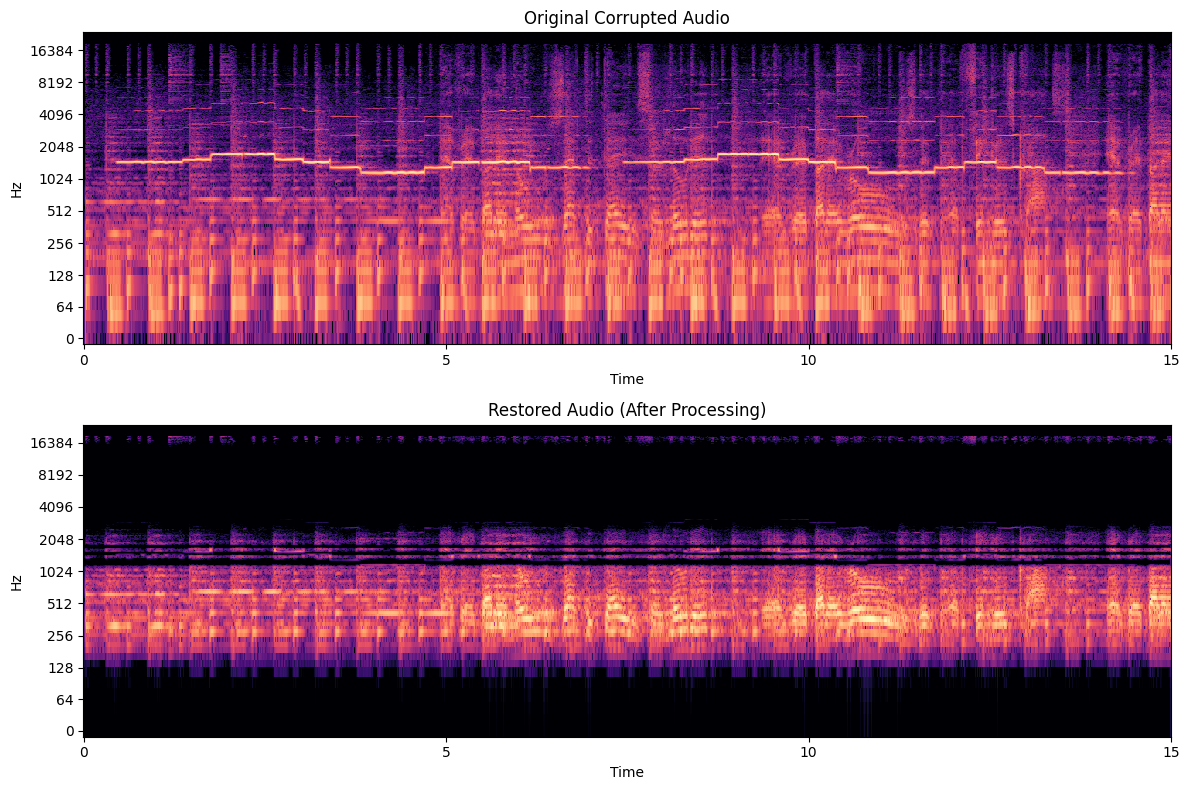

In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal


# AUDIO PROCESSING
# --- 1. Load Audio File ---
print("--- Step 1: Loading Audio ---")
audio_data, sample_rate = librosa.load(
    '/content/drive/My Drive/EE200 Project/Problem2/song_with_2piccolo.wav',
    sr=None, mono=True, dtype=np.float64
)
print(f"Loaded audio file. Sample Rate: {sample_rate} Hz.")

# FILTER DESIGN PARAMETERS

# High-frequency band-stop filters (minor contributors)
high_bandstop1_low = 1700.0
high_bandstop1_high = 17200.0
high_bandstop1_order = 4

high_bandstop2_low = 4000.0
high_bandstop2_high = 16000.0
high_bandstop2_order = 4

# Core frequency filters (major contributors)
highpass_cutoff = 250.0  # Target percussive elements
highpass_order = 5

fundamental_bandstop_low = 1100.0
fundamental_bandstop_high = 1400.0
fundamental_bandstop_order = 4

harmonic_bandstop_low = 1650.0
harmonic_bandstop_high = 1850.0
harmonic_bandstop_order = 4

refinement_bandstop_low = 1420.0
refinement_bandstop_high = 1600.0
refinement_bandstop_order = 4


#    FILTER COEFFICIENT DESIGN

# Design high-frequency band-stop filters
b_high_bs1, a_high_bs1 = signal.butter(
    high_bandstop1_order,
    [high_bandstop1_low, high_bandstop1_high],
    btype='bandstop',
    fs=sample_rate
)
print(f"Designed band-stop filter: {high_bandstop1_low}-{high_bandstop1_high} Hz")

b_high_bs2, a_high_bs2 = signal.butter(
    high_bandstop2_order,
    [high_bandstop2_low, high_bandstop2_high],
    btype='bandstop',
    fs=sample_rate
)
print(f"Designed band-stop filter: {high_bandstop2_low}-{high_bandstop2_high} Hz")

# Design core processing filters
print("\n--- Step 2: Designing Filter Cascade ---")

# High-pass for low-frequency beats
b_hpf, a_hpf = signal.butter(
    highpass_order,
    highpass_cutoff,
    btype='highpass',
    fs=sample_rate
)
print(f"Designed high-pass filter: <{highpass_cutoff} Hz cutoff")

# Fundamental piccolo frequency removal
b_fundamental_bs, a_fundamental_bs = signal.butter(
    fundamental_bandstop_order,
    [fundamental_bandstop_low, fundamental_bandstop_high],
    btype='bandstop',
    fs=sample_rate
)
print(f"Designed band-stop filter: {fundamental_bandstop_low}-{fundamental_bandstop_high} Hz")

# Harmonic frequency removal
b_harmonic_bs, a_harmonic_bs = signal.butter(
    harmonic_bandstop_order,
    [harmonic_bandstop_low, harmonic_bandstop_high],
    btype='bandstop',
    fs=sample_rate
)
print(f"Designed band-stop filter: {harmonic_bandstop_low}-{harmonic_bandstop_high} Hz")

# Fundamental refinement
b_refinement_bs, a_refinement_bs = signal.butter(
    refinement_bandstop_order,
    [refinement_bandstop_low, refinement_bandstop_high],
    btype='bandstop',
    fs=sample_rate
)
print(f"Designed refinement band-stop: {refinement_bandstop_low}-{refinement_bandstop_high} Hz")


#      CASCADE FILTER APPLICATION

print("\n--- Step 3: Applying Filter Cascade ---")

# Initialize processing pipeline
processed_audio = audio_data.copy()

# Apply high-frequency filters first
print("Applying high-frequency band-stop 1...")
processed_audio = signal.filtfilt(b_high_bs1, a_high_bs1, processed_audio)

print("Applying high-frequency band-stop 2...")
processed_audio = signal.filtfilt(b_high_bs2, a_high_bs2, processed_audio)

# Apply core processing filters
print("Applying high-pass filter for beats...")
processed_audio = signal.filtfilt(b_hpf, a_hpf, processed_audio)

print("Applying fundamental band-stop...")
processed_audio = signal.filtfilt(b_fundamental_bs, a_fundamental_bs, processed_audio)

print("Applying harmonic band-stop...")
restored_audio = signal.filtfilt(b_harmonic_bs, a_harmonic_bs, processed_audio)

print("Applying refinement band-stop...")
restored_audio = signal.filtfilt(b_refinement_bs, a_refinement_bs, restored_audio)

print("All filters applied successfully.")

#        OUTPUT AND VISUALIZATION

print("\n--- Step 4: Saving and Visualizing Results ---")

# Normalize and save output
peak_value = np.max(np.abs(restored_audio))
if peak_value > 0:
    normalized_audio = restored_audio / peak_value
else:
    normalized_audio = restored_audio

output_file = 'restored_music.wav'
sf.write(output_file, normalized_audio, sample_rate)
print(f"Saved restored audio to: '{output_file}'")

# Generate spectrogram comparison
def generate_spectrogram(audio, title, sr=sample_rate):
    """Create and display spectrogram"""
    S = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='log')
    plt.title(title)
    return S

# Create comparison figure
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
generate_spectrogram(audio_data, 'Original Corrupted Audio')
plt.subplot(2, 1, 2)
generate_spectrogram(restored_audio, 'Restored Audio (After Processing)')

plt.tight_layout()
plt.show()

In [4]:


#        AUDIO PREVIEW

from IPython.display import Audio

print("Original Audio Preview:")
display(Audio(audio_data, rate=sample_rate))

print("\nRestored Audio Preview:")
display(Audio(normalized_audio, rate=sample_rate))


Original Audio Preview:



Restored Audio Preview:



--- SIGNAL ANALYSIS ---


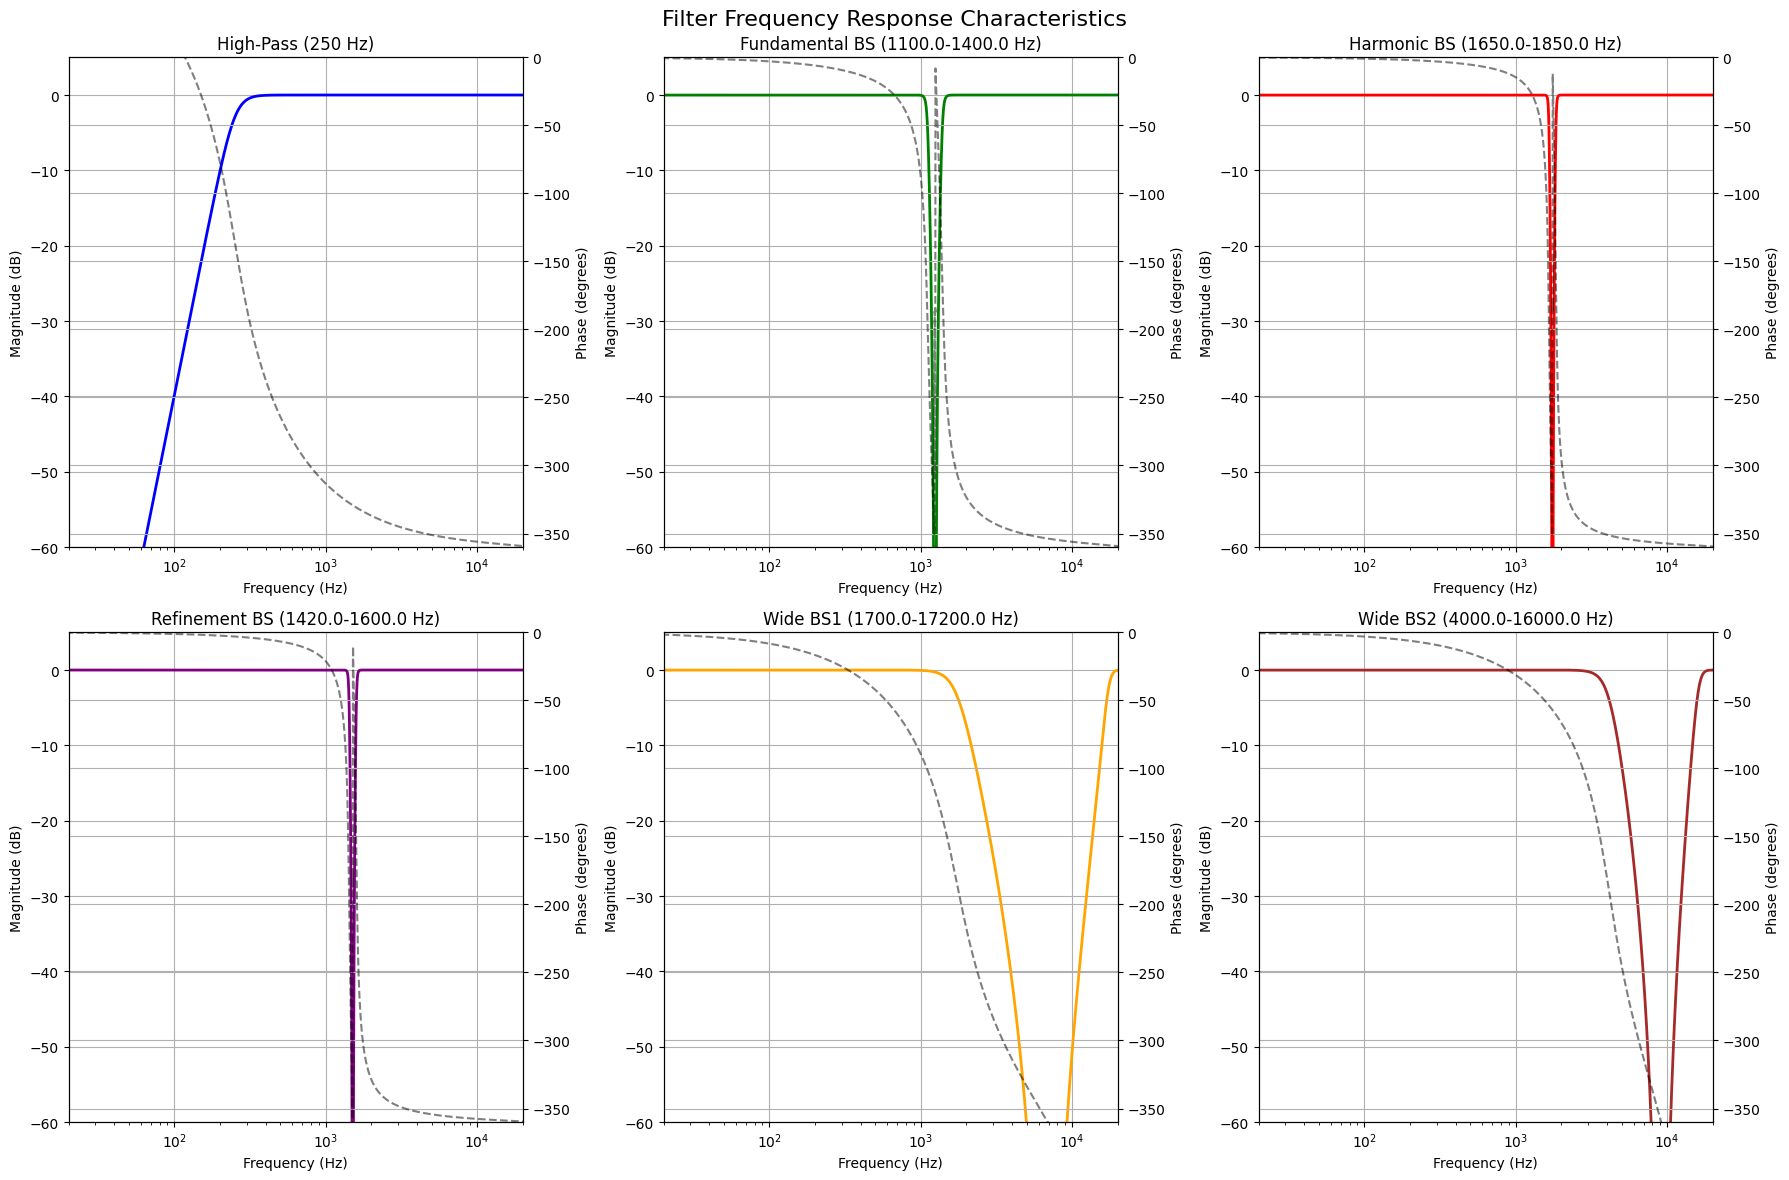

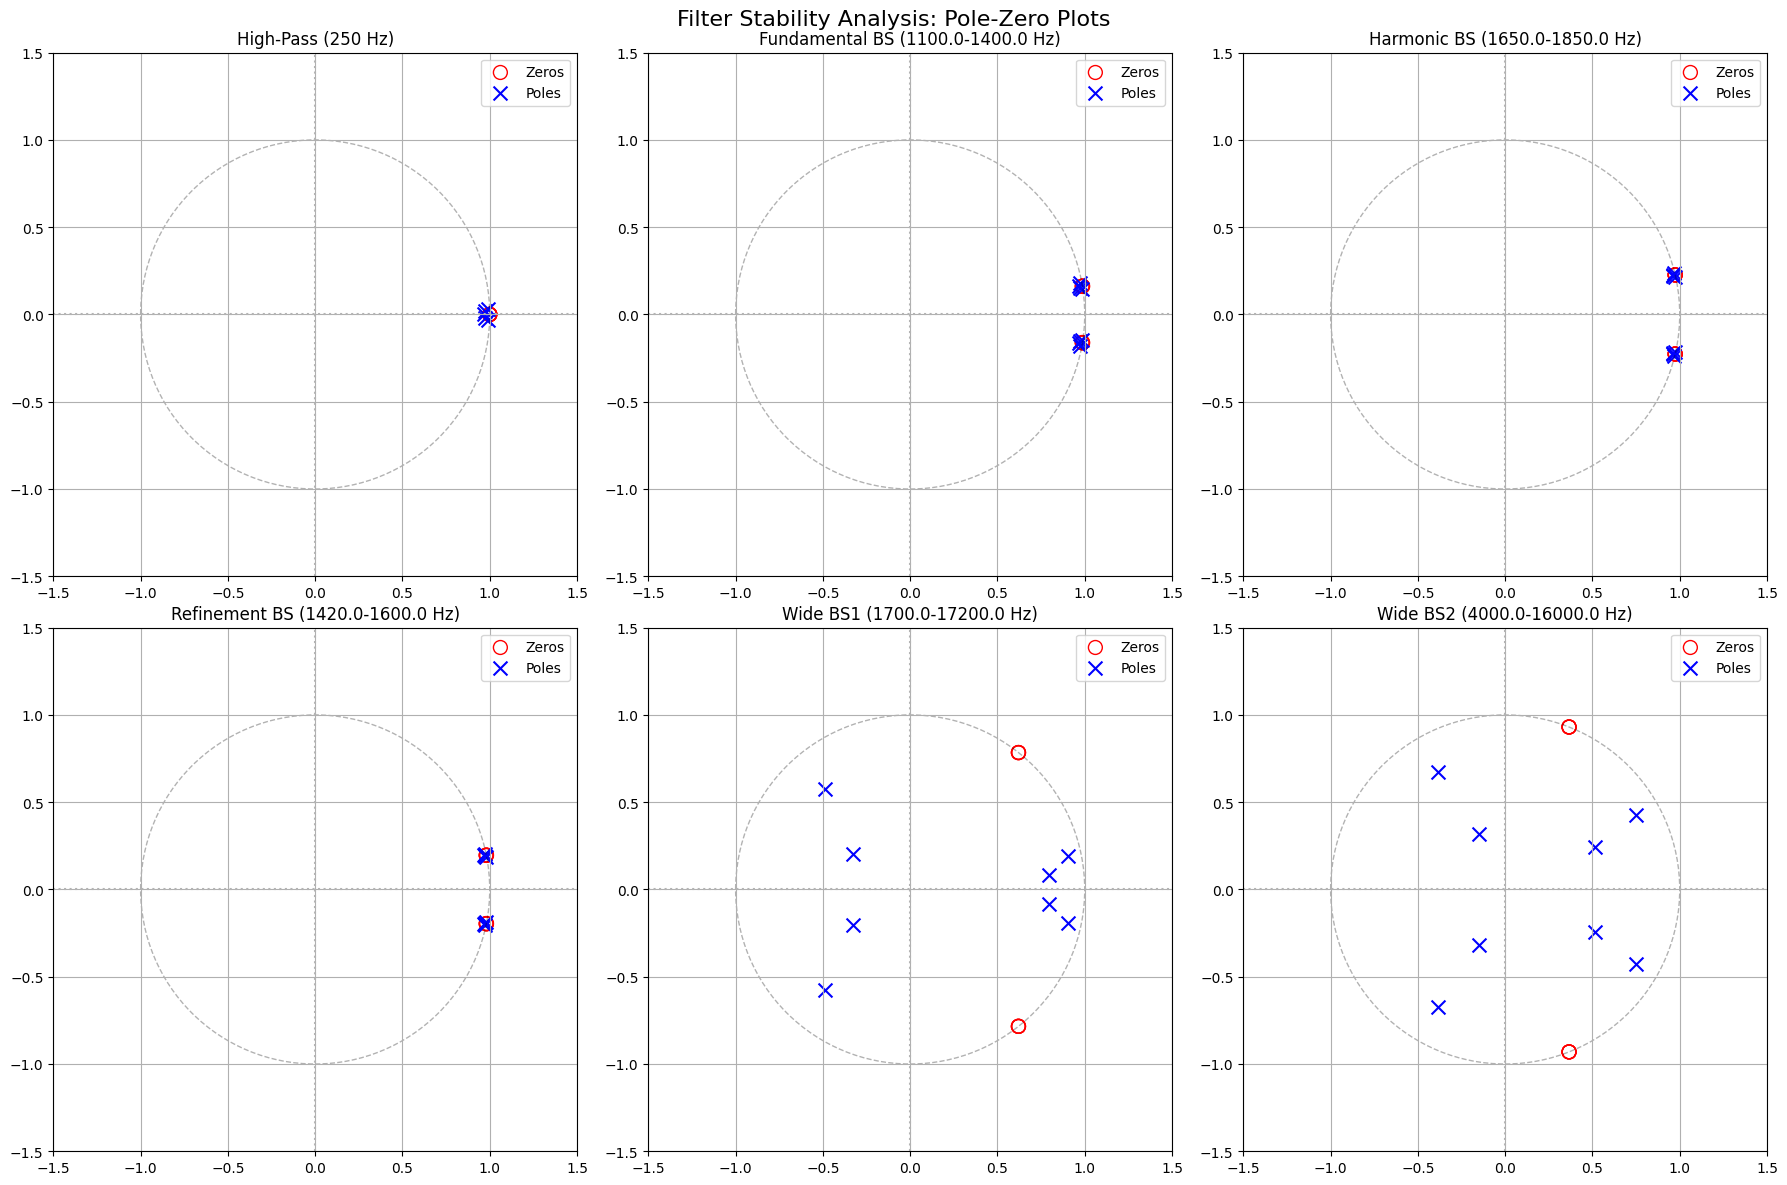

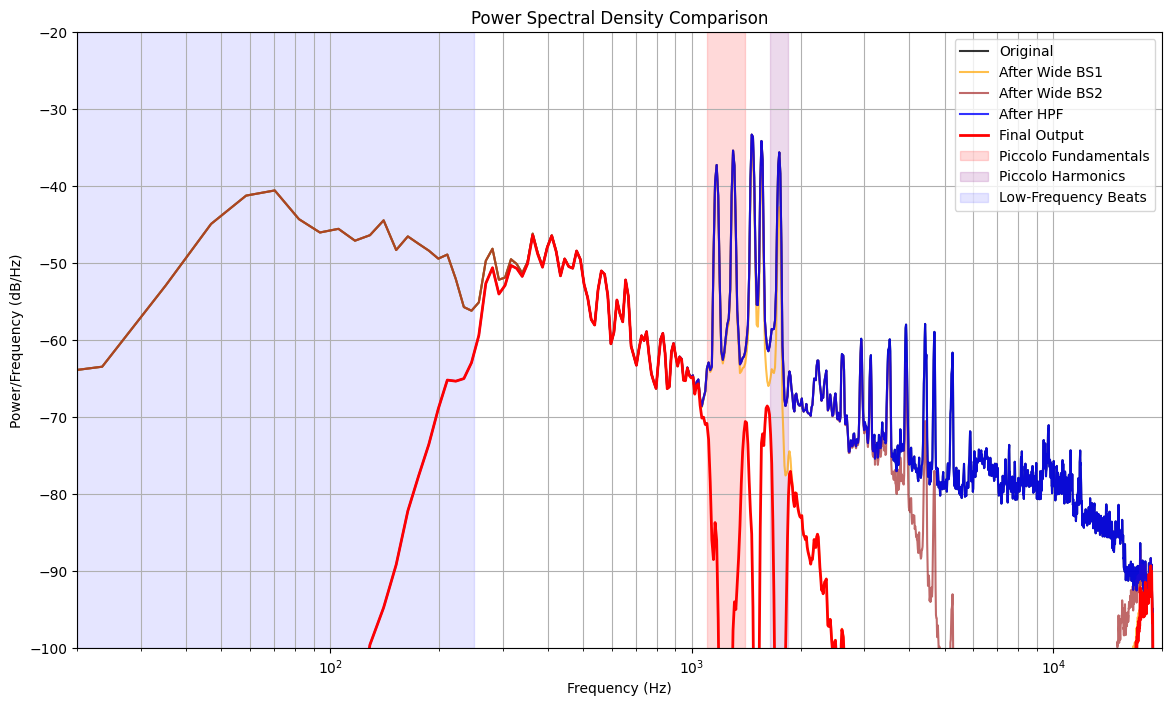

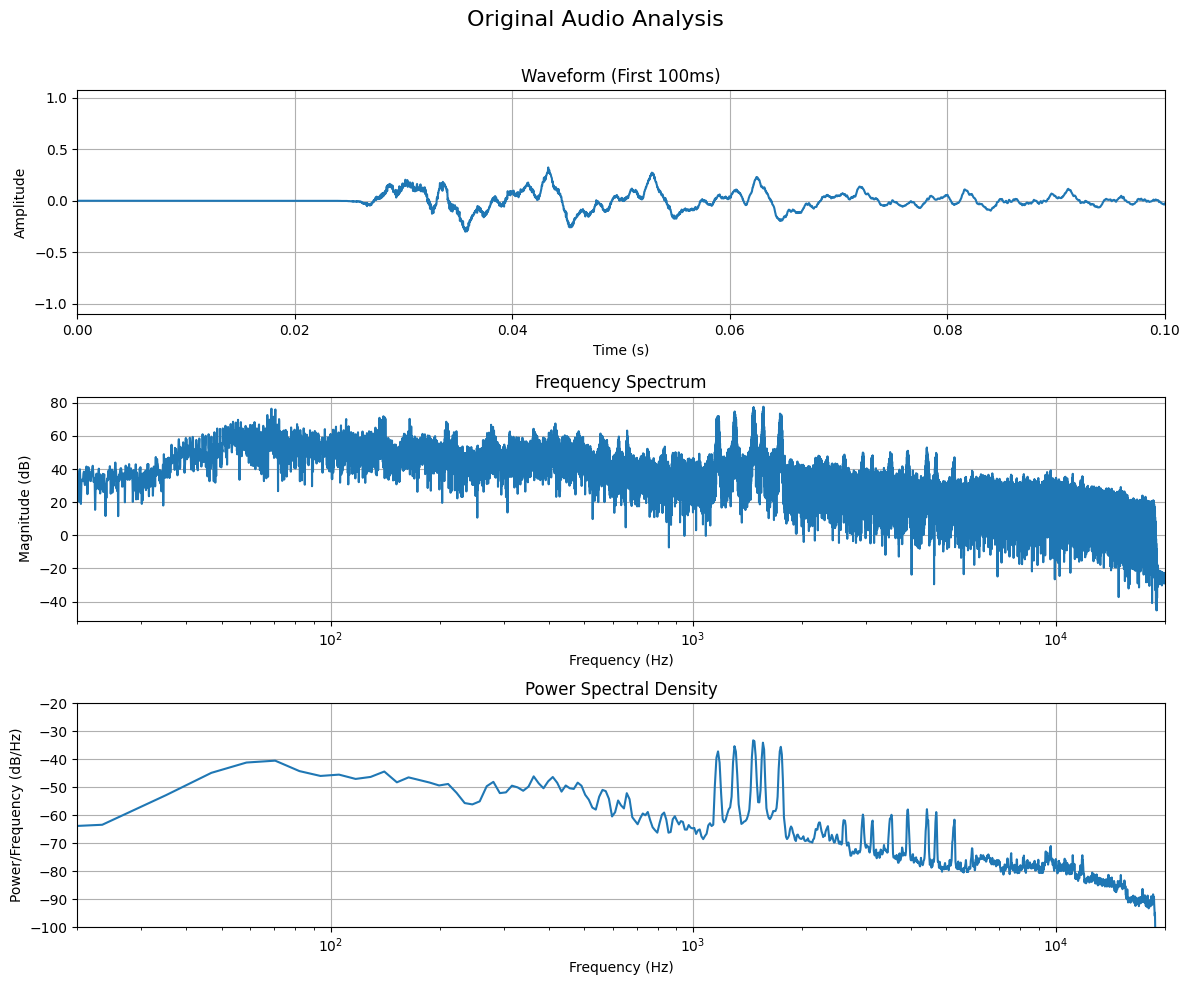

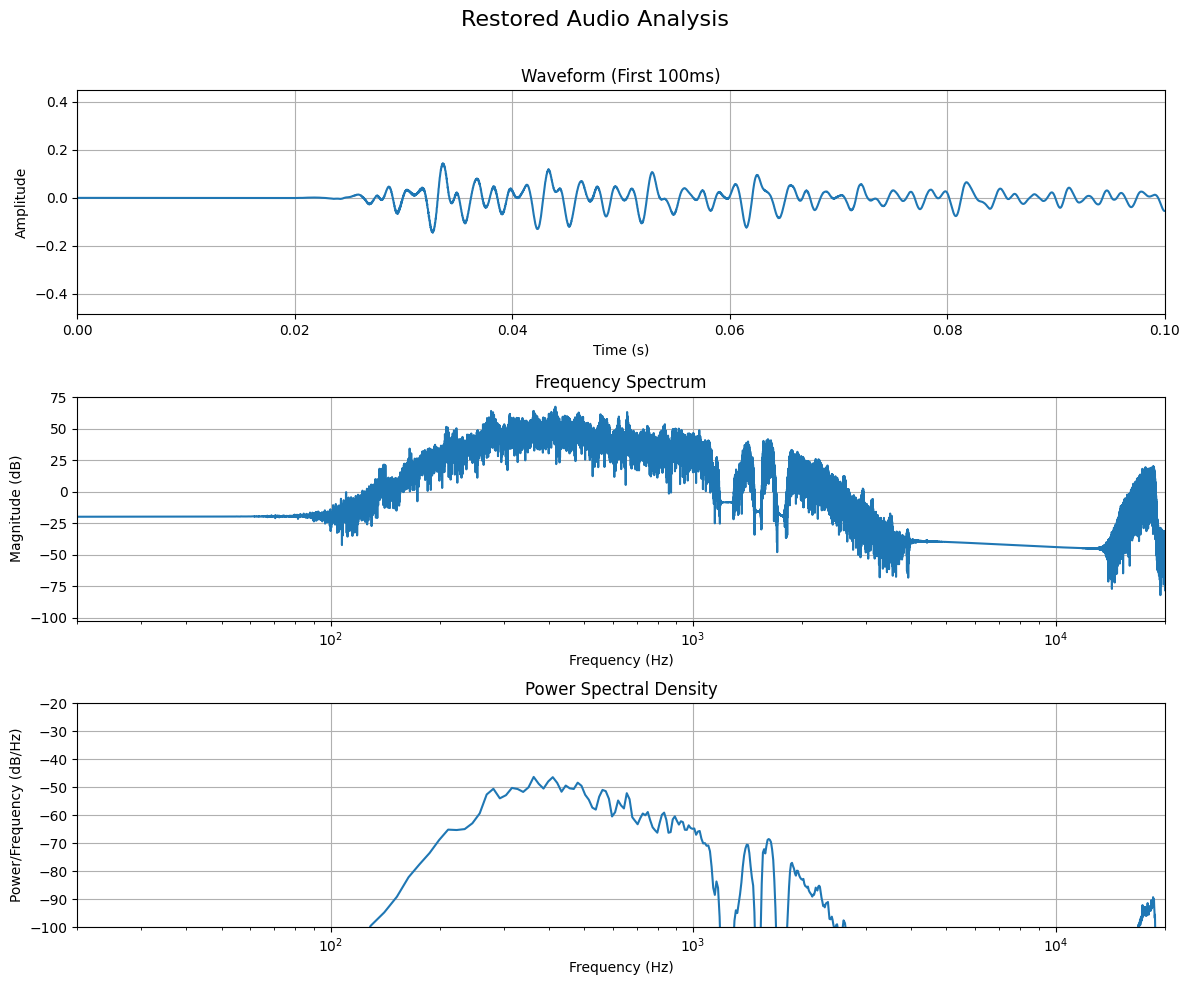

In [5]:

#       FILTER ANALYSIS VISUALIZATION

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Configure plot aesthetics
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.grid'] = True

# Organize filters for analysis
filter_parameters = [
    (b_hpf, a_hpf, 'High-Pass (250 Hz)', 'blue'),
    (b_fundamental_bs, a_fundamental_bs,
     f'Fundamental BS ({fundamental_bandstop_low}-{fundamental_bandstop_high} Hz)', 'green'),
    (b_harmonic_bs, a_harmonic_bs,
     f'Harmonic BS ({harmonic_bandstop_low}-{harmonic_bandstop_high} Hz)', 'red'),
    (b_refinement_bs, a_refinement_bs,
     f'Refinement BS ({refinement_bandstop_low}-{refinement_bandstop_high} Hz)', 'purple'),
    (b_high_bs1, a_high_bs1,
     f'Wide BS1 ({high_bandstop1_low}-{high_bandstop1_high} Hz)', 'orange'),
    (b_high_bs2, a_high_bs2,
     f'Wide BS2 ({high_bandstop2_low}-{high_bandstop2_high} Hz)', 'brown')
]


#         1. BODE PLOT GENERATION

bode_fig, bode_axes = plt.subplots(2, 3, figsize=(18, 12))
bode_fig.suptitle('Filter Frequency Response Characteristics', fontsize=16)

for idx, (b_coeff, a_coeff, filter_name, color) in enumerate(filter_parameters):
    freq, response = signal.freqz(b_coeff, a_coeff, worN=8000, fs=sample_rate)
    magnitude = 20 * np.log10(np.abs(response))
    phase = np.unwrap(np.angle(response)) * 180 / np.pi

    ax = bode_axes[idx//3, idx%3]
    ax.set_title(filter_name)
    ax.semilogx(freq, magnitude, color=color, linewidth=2)
    ax.set_ylabel('Magnitude (dB)')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylim(-60, 5)
    ax.set_xlim(20, 20000)

    phase_ax = ax.twinx()
    phase_ax.semilogx(freq, phase, 'k--', alpha=0.5)
    phase_ax.set_ylabel('Phase (degrees)')
    phase_ax.set_ylim(-360, 0)

plt.tight_layout()
plt.savefig('filter_bode_plots.png', dpi=300)


#       2. POLE-ZERO ANALYSIS

pz_fig, pz_axes = plt.subplots(2, 3, figsize=(18, 12))
pz_fig.suptitle('Filter Stability Analysis: Pole-Zero Plots', fontsize=16)

for idx, (b_coeff, a_coeff, filter_name, _) in enumerate(filter_parameters):
    ax = pz_axes[idx//3, idx%3]
    ax.set_title(filter_name)

    # Calculate poles and zeros
    zeros = np.roots(b_coeff)
    poles = np.roots(a_coeff)

    # Plot zeros
    ax.scatter(np.real(zeros), np.imag(zeros), marker='o', facecolors='none',
               edgecolors='r', s=100, label='Zeros')
    # Plot poles
    ax.scatter(np.real(poles), np.imag(poles), marker='x', color='b',
               s=100, label='Poles')

    # Add stability reference (unit circle)
    unit_circle = plt.Circle((0,0), 1, fill=False, color='k', linestyle='--', alpha=0.3)
    ax.add_patch(unit_circle)

    # Configure plot aesthetics
    ax.axvline(0, color='0.7', linestyle=':')
    ax.axhline(0, color='0.7', linestyle=':')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.legend(loc='best')
    ax.grid(True)

plt.tight_layout()
plt.savefig('filter_pole_zero_plots.png', dpi=300)


#     3. SPECTRAL ANALYSIS COMPARISON

# Compute power spectral densities
freqs, orig_psd = signal.welch(audio_data, fs=sample_rate, nperseg=4096)
_, bs1_psd = signal.welch(signal.filtfilt(b_high_bs1, a_high_bs1, audio_data),
                          fs=sample_rate, nperseg=4096)
_, bs2_psd = signal.welch(signal.filtfilt(b_high_bs2, a_high_bs2, audio_data),
                          fs=sample_rate, nperseg=4096)
_, hpf_psd = signal.welch(signal.filtfilt(b_hpf, a_hpf, audio_data),
                          fs=sample_rate, nperseg=4096)
_, final_psd = signal.welch(restored_audio, fs=sample_rate, nperseg=4096)

# Create PSD comparison plot
plt.figure(figsize=(14, 8))
plt.semilogx(freqs, 10*np.log10(orig_psd), 'k-', alpha=0.8, label='Original')
plt.semilogx(freqs, 10*np.log10(bs1_psd), 'orange', alpha=0.7, label='After Wide BS1')
plt.semilogx(freqs, 10*np.log10(bs2_psd), 'brown', alpha=0.7, label='After Wide BS2')
plt.semilogx(freqs, 10*np.log10(hpf_psd), 'blue', alpha=0.8, label='After HPF')
plt.semilogx(freqs, 10*np.log10(final_psd), 'r-', linewidth=2, label='Final Output')

# Highlight target frequency regions
plt.axvspan(1100, 1400, color='red', alpha=0.15, label='Piccolo Fundamentals')
plt.axvspan(1650, 1850, color='purple', alpha=0.15, label='Piccolo Harmonics')
plt.axvspan(20, 250, color='blue', alpha=0.1, label='Low-Frequency Beats')

plt.title('Power Spectral Density Comparison')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.xlim(20, 20000)
plt.ylim(-100, -20)
plt.legend(loc='upper right')
plt.grid(True, which="both", ls="-")
plt.savefig('psd_comparison.png', dpi=300)


#     4. DETAILED SIGNAL ANALYSIS

def analyze_signal(audio, sample_rate, title):
    """Comprehensive analysis of audio signal"""
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    fig.suptitle(title, fontsize=16)

    # Time-domain waveform (first 100ms)
    time = np.arange(len(audio)) / sample_rate
    axes[0].plot(time, audio)
    axes[0].set_xlim(0, 0.1)
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    axes[0].set_title('Waveform (First 100ms)')

    # Frequency spectrum (FFT)
    n = len(audio)
    freq_spectrum = np.fft.rfft(audio)
    magnitude = np.abs(freq_spectrum)
    freqs = np.fft.rfftfreq(n, d=1/sample_rate)
    axes[1].semilogx(freqs, 20 * np.log10(magnitude + 1e-10))
    axes[1].set_xlim(20, 20000)
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('Magnitude (dB)')
    axes[1].set_title('Frequency Spectrum')

    # Power Spectral Density (PSD)
    freqs, psd = signal.welch(audio, sample_rate, nperseg=4096)
    axes[2].semilogx(freqs, 10 * np.log10(psd))
    axes[2].set_xlim(20, 20000)
    axes[2].set_ylim(-100, -20)
    axes[2].set_xlabel('Frequency (Hz)')
    axes[2].set_ylabel('Power/Frequency (dB/Hz)')
    axes[2].set_title('Power Spectral Density')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Analyze both original and restored audio
print("\n--- SIGNAL ANALYSIS ---")
analyze_signal(audio_data, sample_rate, "Original Audio Analysis")
analyze_signal(restored_audio, sample_rate, "Restored Audio Analysis")